In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from scipy.stats import cauchy
import powerlaw
import networkx as nx
import random
from Person import Person
from EnronEmail import EnronEmail
from DegreeDistribution import DegreeDistribution

In [45]:
emails = pd.read_csv('active_emails/active_emails.csv')

In [46]:
emails['recipients'] = emails['recipients'].apply(lambda x: x.split(' '))
emails

,sender,recipients,date,subject,message_id,day_of_week,hour_of_week
0,chris.foster@enron.com,[kim.ward@enron.com],2001-01-01 01:38:00+00:00,2001 natural gas forecast,<29779853.1075851847407.JavaMail.evans@thyme>,0,1
1,sue.nord@enron.com,[margo.reyna@enron.com],2001-01-01 04:29:00+00:00,Re: CA Quarterly Fee Statement,<28595177.1075843766562.JavaMail.evans@thyme>,0,4
2,sue.nord@enron.com,"[barbara.hueter@enron.com, jeff.dasovich@enron...",2001-01-01 04:59:00+00:00,Re: Ohio Telecommunications Legislation,<17528586.1075843766536.JavaMail.evans@thyme>,0,4
3,sheila.tweed@enron.com,"[mark.haedicke@enron.com, elizabeth.sager@enro...",2001-01-01 05:11:00+00:00,Commission Hearings on Rate Stabilization Plan...,<20708722.1075853232986.JavaMail.evans@thyme>,0,5
4,john.arnold@enron.com,[john.lavorato@enron.com],2001-01-01 08:36:00+00:00,Re:,<27978344.1075857641184.JavaMail.evans@thyme>,0,8
...,...,...,...,...,...,...,...
98236,system.administrator@enron.com,[elizabeth.sager@enron.com],2001-12-31 23:00:06+00:00,Your mailbox is over its size limit,<5967809.1075859126213.JavaMail.evans@thyme>,0,23
98237,system.administrator@enron.com,[kay.mann@enron.com],2001-12-31 23:00:11+00:00,Your mailbox is over its size limit,<24436699.1075855246109.JavaMail.evans@thyme>,0,23
98238,system.administrator@enron.com,[b..sanders@enron.com],2001-12-31 23:00:14+00:00,Your mailbox is over its size limit,<3308063.1075859457637.JavaMail.evans@thyme>,0,23
98239,system.administrator@enron.com,[d..steffes@enron.com],2001-12-31 23:00:34+00:00,Your mailbox is over its size limit,<30237259.1075855209614.JavaMail.evans@thyme>,0,23


In [47]:
num_replies = emails['subject'].str.startswith("RE:").sum()
num_forwards = emails['subject'].str.startswith(("Fw:", "Fwd:", "FW:")).sum()
num_starters = len(emails) - num_replies - num_forwards

print(num_replies, num_forwards, num_starters)

20565 14890 62786


In [48]:
probabilities = [num_replies, num_forwards]
probabilities = [prob / num_starters for prob in probabilities]
print(probabilities)

[0.32754117159876406, 0.23715477972796484]


In [49]:
emails['date'] = pd.to_datetime(emails['date'], utc=True, infer_datetime_format=True)
emails.head()

/var/folders/1w/ty9_z0y12r72xymhb930rg9h0000gn/T/ipykernel_78566/1484915781.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  emails['date'] = pd.to_datetime(emails['date'], utc=True, infer_datetime_format=True)


,sender,recipients,date,subject,message_id,day_of_week,hour_of_week
0,chris.foster@enron.com,[kim.ward@enron.com],2001-01-01 01:38:00+00:00,2001 natural gas forecast,<29779853.1075851847407.JavaMail.evans@thyme>,0,1
1,sue.nord@enron.com,[margo.reyna@enron.com],2001-01-01 04:29:00+00:00,Re: CA Quarterly Fee Statement,<28595177.1075843766562.JavaMail.evans@thyme>,0,4
2,sue.nord@enron.com,"[barbara.hueter@enron.com, jeff.dasovich@enron...",2001-01-01 04:59:00+00:00,Re: Ohio Telecommunications Legislation,<17528586.1075843766536.JavaMail.evans@thyme>,0,4
3,sheila.tweed@enron.com,"[mark.haedicke@enron.com, elizabeth.sager@enro...",2001-01-01 05:11:00+00:00,Commission Hearings on Rate Stabilization Plan...,<20708722.1075853232986.JavaMail.evans@thyme>,0,5
4,john.arnold@enron.com,[john.lavorato@enron.com],2001-01-01 08:36:00+00:00,Re:,<27978344.1075857641184.JavaMail.evans@thyme>,0,8


In [50]:
# extract day of week as integer
emails['day_of_week'] = emails['date'].dt.dayofweek
emails['hour_of_week'] = emails['date'].dt.hour + emails['day_of_week'] * 24
emails.head()

,sender,recipients,date,subject,message_id,day_of_week,hour_of_week
0,chris.foster@enron.com,[kim.ward@enron.com],2001-01-01 01:38:00+00:00,2001 natural gas forecast,<29779853.1075851847407.JavaMail.evans@thyme>,0,1
1,sue.nord@enron.com,[margo.reyna@enron.com],2001-01-01 04:29:00+00:00,Re: CA Quarterly Fee Statement,<28595177.1075843766562.JavaMail.evans@thyme>,0,4
2,sue.nord@enron.com,"[barbara.hueter@enron.com, jeff.dasovich@enron...",2001-01-01 04:59:00+00:00,Re: Ohio Telecommunications Legislation,<17528586.1075843766536.JavaMail.evans@thyme>,0,4
3,sheila.tweed@enron.com,"[mark.haedicke@enron.com, elizabeth.sager@enro...",2001-01-01 05:11:00+00:00,Commission Hearings on Rate Stabilization Plan...,<20708722.1075853232986.JavaMail.evans@thyme>,0,5
4,john.arnold@enron.com,[john.lavorato@enron.com],2001-01-01 08:36:00+00:00,Re:,<27978344.1075857641184.JavaMail.evans@thyme>,0,8


In [51]:
# show emails sorted by date
emails.sort_values('date', inplace=True)
emails.head()

,sender,recipients,date,subject,message_id,day_of_week,hour_of_week
0,chris.foster@enron.com,[kim.ward@enron.com],2001-01-01 01:38:00+00:00,2001 natural gas forecast,<29779853.1075851847407.JavaMail.evans@thyme>,0,1
1,sue.nord@enron.com,[margo.reyna@enron.com],2001-01-01 04:29:00+00:00,Re: CA Quarterly Fee Statement,<28595177.1075843766562.JavaMail.evans@thyme>,0,4
2,sue.nord@enron.com,"[barbara.hueter@enron.com, jeff.dasovich@enron...",2001-01-01 04:59:00+00:00,Re: Ohio Telecommunications Legislation,<17528586.1075843766536.JavaMail.evans@thyme>,0,4
3,sheila.tweed@enron.com,"[mark.haedicke@enron.com, elizabeth.sager@enro...",2001-01-01 05:11:00+00:00,Commission Hearings on Rate Stabilization Plan...,<20708722.1075853232986.JavaMail.evans@thyme>,0,5
4,john.arnold@enron.com,[john.lavorato@enron.com],2001-01-01 08:36:00+00:00,Re:,<27978344.1075857641184.JavaMail.evans@thyme>,0,8


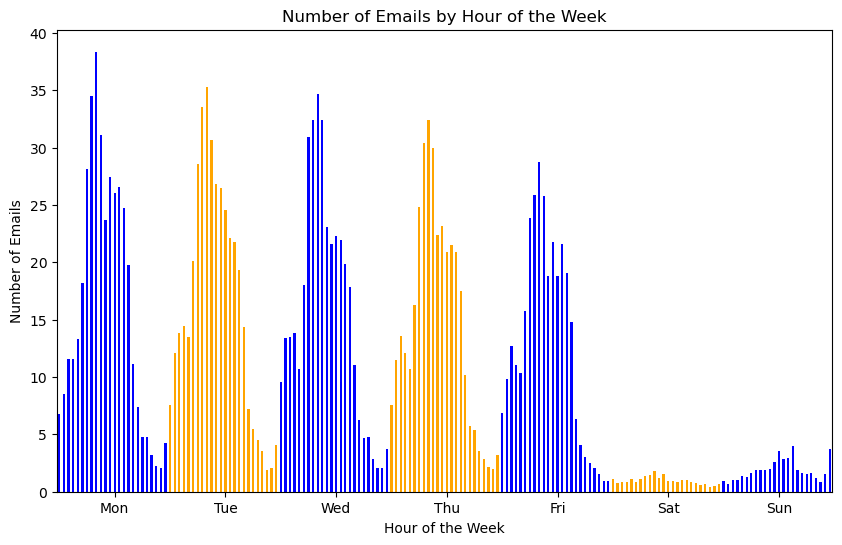

In [52]:
# Group the emails by hour of the week and calculate the size of each group
grouped_emails = emails.groupby('hour_of_week').size()

# Calculate the average number of emails per hour
average_emails = grouped_emails / (365 / 7)

colors = ['blue' if (hour // 24) % 2 == 0 else 'orange' for hour in range(168)]

# Plot the number of emails by hour of the week
average_emails.plot(kind='bar', color=colors, figsize=(10, 6))

# Set the x and y-axis labels
plt.xlabel('Hour of the Week')
plt.ylabel('Number of Emails')

plt.xticks(range(12, 24 * 7, 24), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)

# Set the title of the plot
plt.title('Number of Emails by Hour of the Week')

# Show the plot
plt.show()

In [53]:
# calculate average number of emails per hour
average_emails = grouped_emails / (365 / 7)
average_emails.head(), len(average_emails)

(hour_of_week
 0     6.808219
 1     8.476712
 2    11.564384
 3    11.564384
 4    13.271233
 dtype: float64,
 168)

In [54]:
all_people = dict()
all_emails = dict()

for index, row in emails.iterrows():
    email = EnronEmail(row['message_id'], row['sender'],
                       row['recipients'], row['date'])
    all_emails[email.id] = email
    if email.sender not in all_people:
        all_people[email.sender] = Person(email.sender)

    for recipient in email.recipients:
        if recipient not in all_people:
            all_people[recipient] = Person(recipient)
        all_people[recipient].received[email.id] = email
        all_people[email.sender].sent[email.id] = email
        all_people[email.sender].recipients.add(recipient)

In [55]:
data = {'Email': [], 'Received': [], 'Sent': [], 'Recipients': []}

for person in all_people.values():
    data['Email'].append(person.email)
    data['Received'].append(len(person.received))
    data['Sent'].append(len(person.sent))
    data['Recipients'].append(len(person.recipients))

activity = pd.DataFrame(data)
activity

,Email,Received,Sent,Recipients
0,chris.foster@enron.com,77,82,32
1,kim.ward@enron.com,230,64,28
2,sue.nord@enron.com,167,56,25
3,margo.reyna@enron.com,43,8,3
4,barbara.hueter@enron.com,32,6,14
...,...,...,...,...
5550,schlecht.schlecht@enron.com,0,1,1
5551,maintenance.dl-exchange@enron.com,52,0,0
5552,michael.green@enron.com,1,1,10
5553,ron.spain@enron.com,0,1,1


In [56]:
graph = nx.DiGraph()

for person in all_people.values():
    for email in person.sent.values():
        for recipient in email.recipients:
            graph.add_edge(person.email, recipient)
            
print(len(graph.nodes), len(graph.edges))

5555 47728


In [57]:
# create dictionaries for the number of people who received/sent a certain number of emails
sent = dict()
received = dict()
recipients = dict() # number different people someone emailed

for person in all_people.values():
    num_sent = len(person.sent)
    sent[len(person.sent)] = sent.get(num_sent, 0) + 1
    
    num_received = len(person.received)
    received[num_received] = received.get(num_received, 0) + 1
    
    num_recipients = len(person.recipients)
    recipients[num_recipients] = recipients.get(num_recipients, 0) + 1

In [58]:
#create an array of the number of emails received by each person
num_received = []
num_sent = []
num_recipients = []
for person in all_people.values():
    num_received.append(len(person.received))
    num_sent.append(len(person.sent))
    num_recipients.append(len(person.recipients))

# fit the powerlaw model
fit_received = powerlaw.Fit(num_received)
fit_sent = powerlaw.Fit(num_sent)
fit_recipients = powerlaw.Fit(num_recipients)

print(f'Received fit: {fit_received.alpha}')
print(f'Sent fit: {fit_sent.alpha}')
print(f'Recipients fit: {fit_recipients.alpha}')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Received fit: 2.5385204169300635
Sent fit: 2.0807028929278344
Recipients fit: 2.979529872531982


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


In [59]:
print(sorted(recipients, reverse=True)[:10])

[288, 270, 240, 223, 214, 199, 198, 194, 181, 173]


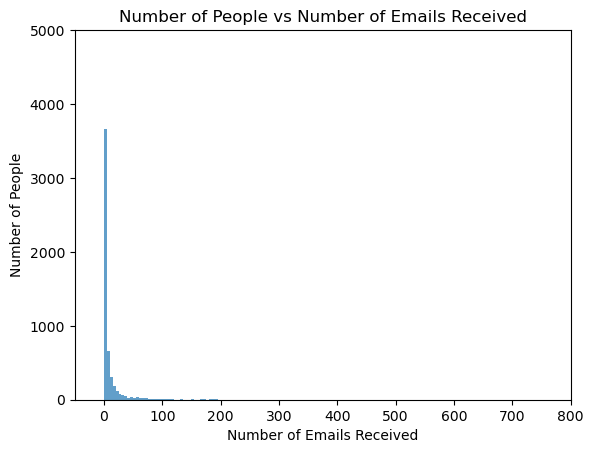

In [60]:
# Create a list for the number of emails received by each person
num_activity = [len(person.sent) for person in all_people.values()]
# num_activity = [len(person.recipients) for person in all_people.values()]
# Create a list of bin edges from the minimum to the maximum number of emails received, with a step size of 100
bin_size = 5
bins = range(min(num_activity), max(num_activity) + bin_size, bin_size)

# Plot the histogram
plt.xlim(-50, 800)
plt.ylim(0, 5000)
plt.hist(num_activity, bins=bins, width=bin_size, alpha=0.7)
plt.xlabel('Number of Emails Received')
plt.ylabel('Number of People')
plt.title('Number of People vs Number of Emails Received')
plt.show()

In [61]:
def get_log_log(activity_dict: dict):
    x = list(activity_dict.keys())
    y = list(activity_dict.values())
    y = [val / sum(y) for val in y]
    # Plot the log-log graph
    plt.loglog(x, y, marker='o', linestyle='')
    plt.xlabel('log(out_degree)')
    plt.ylabel('log(number of people)')
    plt.title('Number of Emails Sent vs Number of People')
    return plt

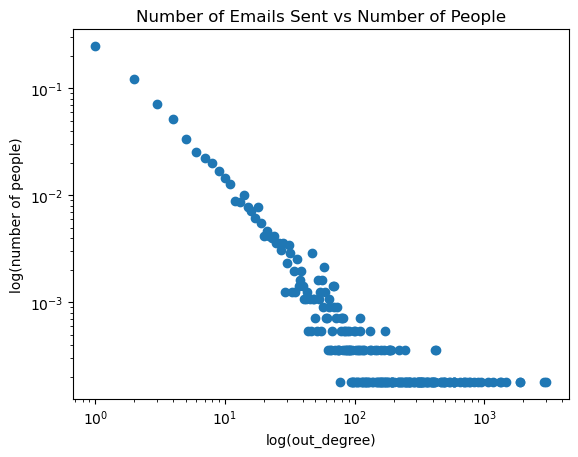

In [62]:
plt_sent = get_log_log(sent)
plt_sent.show()

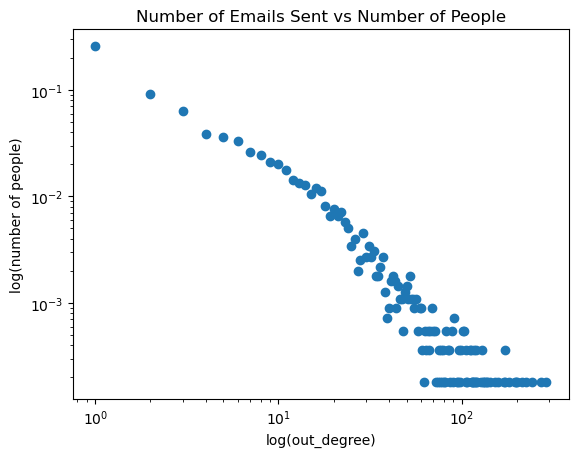

In [63]:
plt_recipients = get_log_log(recipients)
plt_recipients.show()

In [64]:
# Define the empirical distribution of degrees (number of emails sent)
sent_dist = DegreeDistribution(sent)
recipients_dist = DegreeDistribution(recipients)

In [69]:
# the index is the degree and the value is the probability of that degree
sent_freq_dist = np.zeros(max(sent_dist.degrees) + 1)
for sent_degree, probability in zip(sent_dist.degrees, sent_dist.probabilities):
    sent_freq_dist[sent_degree] = probability

print(len(sent_freq_dist), max(sent_dist.degrees))

3000 2999


In [71]:
recipients_freq_dist = np.zeros(max(recipients_dist.degrees) + 1)
for recipients_degree, probability in zip(recipients_dist.degrees, recipients_dist.probabilities):
    recipients_freq_dist[recipients_degree] = probability

print(len(recipients_freq_dist), max(recipients.keys()))

289 288


In [72]:
def node_dp_degree_approximation(epsilon: float, theta: int, degree_dict: dict, deg_dist: np.ndarray):
    beta = epsilon / (np.sqrt(2) * (theta + 1))
    St_naive = 0  # smooth upper bound on local sensitivity of Naive Truncation
    for k in range(1, theta + 1):
        n = len([d for d in degree_dict.keys() if theta - k <= d <= theta + k])
        curr_s = (np.exp(-beta * k)) * (1 + k + n)
        St_naive = max(St_naive, curr_s)
        
    cauchy_scale = np.sqrt(2) * theta * St_naive / epsilon
    print('cauchy scale', cauchy_scale)
    cauchy_noise = cauchy.rvs(loc=0, scale=cauchy_scale, size=theta + 1)
    noisy_degs = deg_dist[:theta + 1] + cauchy_noise
    noisy_degs = np.maximum(noisy_degs, 0)
    noisy_degs = noisy_degs / sum(noisy_degs)
    
    return noisy_degs

In [73]:
approx_degrees = node_dp_degree_approximation(epsilon=0.1, theta=8, degree_dict=sent, deg_dist=sent_freq_dist)
approx_degrees

cauchy scale 2762.365969635189


array([0.008491  , 0.        , 0.        , 0.08942919, 0.06645444,
       0.71229956, 0.07882719, 0.0429064 , 0.00159222])

In [74]:
# generate N independent random draws from the distribution. If sum is odd, add 1 to the smallest degree
def get_sorted_random_degree_sequence(deg_dist: DegreeDistribution, seq_size: int) -> np.ndarray:
    random_degrees = np.random.choice(
        deg_dist.degrees, size=seq_size, replace=True, p=deg_dist.probabilities)
    if sum(random_degrees) % 2 != 0:
        random_degrees[np.argmin(random_degrees)] += 1

    return np.sort(random_degrees)[::-1]


def get_capped_degree_seq(seq_size: int, deg_dist: DegreeDistribution) -> DegreeDistribution:
    degrees, probs = deg_dist.degrees, deg_dist.probabilities
    for i, degree in enumerate(degrees):
        if degree > seq_size:
            max_allowed_deg_idx = i - 1
            break
    else:
        max_allowed_deg_idx = len(degrees) - 1

    ds = degrees[:max_allowed_deg_idx]
    ps = probs[:max_allowed_deg_idx]
    # normalise the probabilities
    ps = [prob / sum(ps) for prob in ps]

    return DegreeDistribution(dict(zip(ds, ps)))

In [75]:
SEQ_SIZE = 2000
capped_sent_dist = get_capped_degree_seq(seq_size=SEQ_SIZE, deg_dist=sent_dist)
sorted_random_sents = get_sorted_random_degree_sequence(deg_dist=capped_sent_dist, seq_size=SEQ_SIZE)

capped_recipients_dist = get_capped_degree_seq(seq_size=SEQ_SIZE, deg_dist=recipients_dist)
sorted_random_recipients = get_sorted_random_degree_sequence(deg_dist=capped_recipients_dist, seq_size=SEQ_SIZE)

In [76]:
print(sorted_random_recipients, len(sorted_random_recipients))

[240 199 138 ...   0   0   0] 2000


In [77]:
def get_candidate_nodes(sorted_degrees) -> list[int]: # residual_degs
    candidate_nodes = []
    for i, deg in enumerate(sorted_degrees):
        candidate_nodes += [i] * deg
    return candidate_nodes


def get_random_graph_from_degree(deg_seq: np.ndarray) -> np.ndarray:
    N = len(deg_seq)
    if sum(deg_seq) % 2 != 0:
        deg_seq[-1] += 1
    
    def fill_adj_matrix(res_degs, c, m, x):
        matrix = np.zeros((N, N))
        while res_degs:
            i = res_degs[0]
            valid_j = False
            while not valid_j:
                # pick a random index from the residual degrees (recipient of person i)
                idx = random.randint(1, len(res_degs) - 1)
                j = res_degs[idx]
                if i == j or matrix[i, j] > 0:
                    c += 1
                    if c >= m:
                        return None
                else:
                    valid_j = True
            matrix[i, j], matrix[j, i] = 1, 1
            if x > 0 and x % 100 == 0:
                print('here', x, i)
            res_degs.pop(idx)
            res_degs.pop(0)
                
        return matrix 
    
    residual_degs = get_candidate_nodes(deg_seq)
    adj_matrix = None
    x = 0
    while adj_matrix is None:
        adj_matrix = fill_adj_matrix(res_degs=residual_degs.copy(), c=0, m=2000, x=x)
        x += 1
    return adj_matrix

In [78]:
random_graph = get_random_graph_from_degree(sorted_random_recipients)
random_graph

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## K means clustering

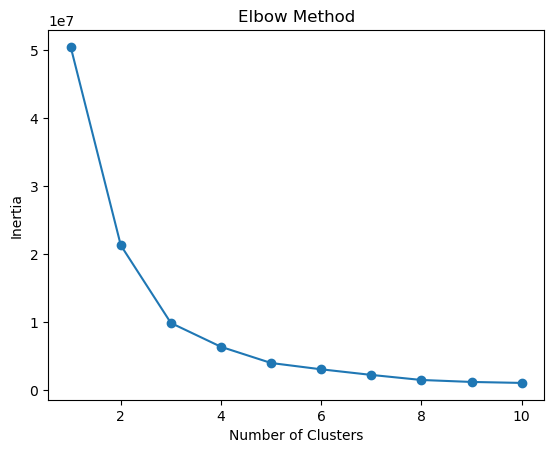

In [79]:
# Features for clustering
# X = activity[['Sent']]
X = activity[['Sent', 'Recipients']]

inertia = []
for k in range(1, 11):
    # Create a KMeans object with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Fit the model to the data
    kmeans.fit(X)
    # Append the inertia value to the list
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [80]:
n_clusters = 5
X = activity[['Sent', 'Recipients']]
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_means = kmeans.fit_predict(X)
activity['cluster'] = y_means
activity

,Email,Received,Sent,Recipients,cluster
0,chris.foster@enron.com,77,82,32,4
1,kim.ward@enron.com,230,64,28,4
2,sue.nord@enron.com,167,56,25,0
3,margo.reyna@enron.com,43,8,3,0
4,barbara.hueter@enron.com,32,6,14,0
...,...,...,...,...,...
5550,schlecht.schlecht@enron.com,0,1,1,0
5551,maintenance.dl-exchange@enron.com,52,0,0,0
5552,michael.green@enron.com,1,1,10,0
5553,ron.spain@enron.com,0,1,1,0


In [81]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette = silhouette_score(X, y_means)

print(f'Silhouette score: {silhouette}')

Silhouette score: 0.8626484941380362


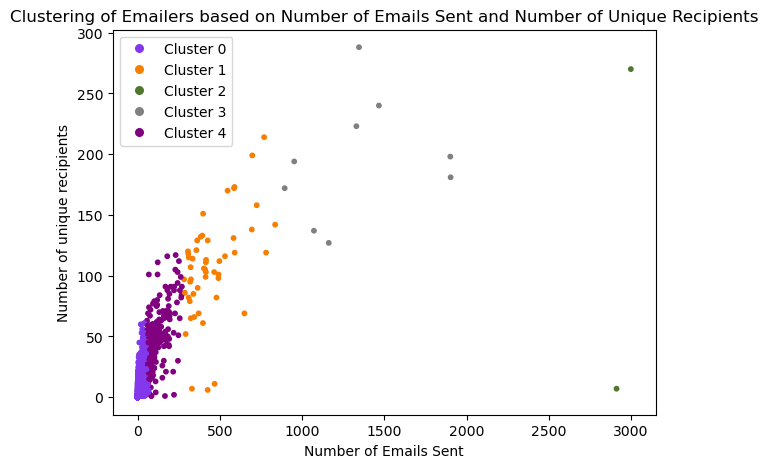

In [82]:
# Define the color map for the clusters
colour_map = {0: '#8338ec', 1: '#f77f00', 2: '#4f772d', 3: 'grey', 4: 'purple', 5: 'pink'}
plt.figure(figsize=(7, 5))

# Create the scatter plot with the specified colors
# plt.scatter(activity['Received'], activity['Sent'], c=activity['cluster'].map(color_map))
# plt.scatter(activity['Sent'], np.zeros(len(X)), c=activity['cluster'].map(colour_map), s=3)
plt.scatter(activity['Sent'], activity['Recipients'],
            c=activity['cluster'].map(colour_map).tolist(), s=10)
plt.ylabel('Number of unique recipients')
plt.xlabel('Number of Emails Sent')
plt.title('Clustering of Emailers based on Number of Emails Sent and Number of Unique Recipients')

# Create the legend
plt.legend(handles=[Line2D([0], [0], marker='.', color='w', label=f'Cluster {cluster_num}', markerfacecolor=colour_map[cluster_num], markersize=15)
                    for cluster_num in range(n_clusters)])

plt.show()

In [83]:
# for each unique value in the recipients column, add to a dictionary a list of probabilities of the value in the recipients column being in each cluster
recipients_cluster_probs = dict()
for num_recipients in recipients.keys():
    recipients_cluster_probs[num_recipients] = np.array([0] * n_clusters)
    
for index, row in activity.iterrows():
    num_recipients = row['Recipients']
    cluster = row['cluster']
    recipients_cluster_probs[num_recipients][cluster] += 1
    
for num_recipients, cluster_probs in recipients_cluster_probs.items():
    recipients_cluster_probs[num_recipients] = cluster_probs / sum(cluster_probs)
        
recipients_cluster_probs

{32: array([0.66666667, 0.        , 0.        , 0.        , 0.33333333]),
 28: array([0.78571429, 0.        , 0.        , 0.        , 0.21428571]),
 25: array([1., 0., 0., 0., 0.]),
 3: array([0.99717514, 0.        , 0.        , 0.        , 0.00282486]),
 14: array([0.97183099, 0.        , 0.        , 0.        , 0.02816901]),
 270: array([0., 0., 1., 0., 0.]),
 47: array([0.33333333, 0.        , 0.        , 0.        , 0.66666667]),
 42: array([0.2, 0. , 0. , 0. , 0.8]),
 15: array([0.98305085, 0.        , 0.        , 0.        , 0.01694915]),
 8: array([0.99259259, 0.        , 0.        , 0.        , 0.00740741]),
 5: array([1., 0., 0., 0., 0.]),
 98: array([0., 1., 0., 0., 0.]),
 24: array([0.82142857, 0.        , 0.        , 0.        , 0.17857143]),
 6: array([0.99453552, 0.00546448, 0.        , 0.        , 0.        ]),
 30: array([0.73333333, 0.        , 0.        , 0.        , 0.26666667]),
 1: array([0.99790503, 0.        , 0.        , 0.        , 0.00209497]),
 94: array([0.,

In [84]:
# create a DegreeDistribution object for the degee of total emails sent in each cluster
sent_cluster_dist = dict()
for cluster_num in range(n_clusters):
    sent_cluster_dist[cluster_num] = dict()
    
for index, row in activity.iterrows():
    cluster = row['cluster']
    sent = row['Sent']
    sent_cluster_dist[cluster][sent] = sent_cluster_dist[cluster].get(sent, 0) + 1
    
for cluster_num, sent_dist in sent_cluster_dist.items():
    sent_cluster_dist[cluster_num] = DegreeDistribution(sent_dist)
    
sent_cluster_dist

{0: DegreeDistribution(activity_dict={56: 9, 8: 112, 6: 142, 47: 16, 16: 40, 31: 19, 12: 49, 7: 125, 1: 1376, 33: 7, 0: 934, 5: 187, 10: 80, 38: 9, 45: 6, 43: 7, 17: 34, 4: 285, 2: 675, 20: 23, 9: 93, 11: 71, 39: 11, 48: 6, 23: 22, 21: 26, 28: 20, 24: 23, 32: 16, 36: 14, 40: 8, 15: 43, 27: 17, 3: 398, 58: 6, 18: 43, 22: 23, 57: 2, 53: 5, 34: 11, 14: 56, 13: 48, 55: 2, 37: 8, 26: 20, 51: 3, 25: 20, 29: 7, 59: 2, 41: 6, 35: 7, 52: 9, 19: 31, 50: 4, 30: 13, 42: 6, 49: 6, 44: 3, 64: 1, 46: 3, 54: 3, 61: 2, 66: 1, 65: 1}),
 1: DegreeDistribution(activity_dict={491: 1, 583: 1, 416: 1, 781: 1, 324: 1, 468: 1, 531: 1, 311: 1, 292: 1, 322: 1, 836: 1, 306: 1, 697: 1, 371: 1, 590: 1, 586: 1, 769: 1, 547: 1, 287: 1, 415: 2, 339: 1, 479: 1, 362: 1, 649: 1, 319: 1, 413: 1, 393: 1, 357: 1, 694: 1, 323: 1, 310: 1, 308: 1, 344: 1, 317: 1, 410: 1, 465: 1, 397: 1, 282: 1, 426: 2, 492: 1, 334: 1, 497: 1, 724: 1, 403: 1, 383: 1, 589: 1, 365: 1, 398: 1, 330: 1}),
 2: DegreeDistribution(activity_dict={2999: 

In [85]:
emails_sent = np.array([0] * len(sorted_random_recipients))
for i, num_recipients in enumerate(sorted_random_recipients):
    sample_cluster = np.random.choice(range(n_clusters), p=recipients_cluster_probs[num_recipients])
    cluster_sent_dist = sent_cluster_dist[sample_cluster]
    # number of sent emails must be at least the number of recipients
    filtered_sent_dist = cluster_sent_dist.get_dist_with_min_degree(min_degree=min(num_recipients, 1))
    num_sent = np.random.choice(filtered_sent_dist.degrees, p=filtered_sent_dist.probabilities)
    emails_sent[i] = num_sent
    
# normalise the distribution
emails_sent = emails_sent / sum(emails_sent)
print(emails_sent)

[3.25318592e-02 7.92505442e-03 8.41425531e-03 ... 7.33801336e-05
 1.22300223e-04 1.71220312e-04]


In [86]:
# scale the number of emails to the number of people in the network
email_scale = SEQ_SIZE / len(all_people)
email_scale

0.36003600360036003

In [92]:
np.mean(average_emails)

11.214726027397258